# Анализ данных о недвижимости

## Источник данных
Набор данных - [Moscow Housing Price Dataset](https://www.kaggle.com/datasets/egorkainov/moscow-housing-price-dataset/data). Данные были собраны в ноябре 2023 года.

Описание данных:

- **Price**: Цена квартиры в рублях. Это основная целевая переменная для прогнозирования.

- **Apartment type**: Новостройка или вторичный рынок

- **Metro station**: Название ближайшей станции метро к апартаментам.

- **Minutes to metro**: Время в минутах, необходимое для того, чтобы дойти от апартаментов до ближайшей станции метро.

- **Region**: Регион, в котором расположена квартира (Москва или Московская область).

- **Number of rooms**: Общее количество комнат в квартире, включая спальни, гостиные и т.д.

- **Area**: Общая площадь квартиры в квадратных метрах.

- **Living area**: Жилая площадь квартиры в квадратных метрах, то есть площадь, пригодная для проживания.

- **Kitchen area**: Площадь кухни в квадратных метрах.

- **Floor**: Этаж, на котором расположена квартира.

- **Number of floors**: Общее количество этажей в здании, где расположена квартира.

- **Renovation**: уровень ремонта квартиры, например, "без ремонта", "косметический ремонт", "евроремонт" и т.д.

In [4]:
!pip install matplotlib seaborn tqdm dadata folium geopandas shapely mysql-connector-python sqlalchemy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 46.1 MB/s eta 0:00:00


In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import Choropleth
from shapely.geometry import Point

from dadata import Dadata

from tqdm import tqdm
from time import sleep
from requests.exceptions import HTTPError

import sqlite3
from sqlalchemy import create_engine
import mysql.connector

import warnings
warnings.filterwarnings("ignore")

# 1. Предобработка и анализ данных

In [ ]:
# df = pd.read_csv('full_data.csv')
df = pd.read_csv('data.csv')
df.head()

Price Apartment type Metro station  Minutes to metro         Region  \
0   6300000.0      Secondary       Опалиха               6.0  Moscow region   
1   9000000.0      Secondary       Павшино               2.0  Moscow region   
2  11090000.0      Secondary      Мякинино              14.0  Moscow region   
3   8300000.0      Secondary      Строгино               8.0  Moscow region   
4   6450000.0      Secondary       Опалиха               6.0  Moscow region   

   Number of rooms  Area  Living area  Kitchen area  Floor  Number of floors  \
0              1.0  30.6         11.1           8.5   25.0                25   
1              1.0  49.2         20.0          10.0    6.0                15   
2              1.0  44.7         16.2          13.1   10.0                25   
3              1.0  35.1         16.0          11.0   12.0                33   
4              1.0  37.7         15.2           4.0    5.0                 5   

                  Renovation  
0                   Cosmetic  
1  European-style renovation  
2                   Cosmetic  
3  European-style renovation  
4         Without renovation

Посмотрим на типы данных в датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22676 non-null  float64
 1   Apartment type    22676 non-null  object 
 2   Metro station     22676 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22676 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22676 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22676 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.1+ MB


Посчитаем пропуски

In [ ]:
df.isna().sum()

Price               0
Apartment type      0
Metro station       0
Minutes to metro    0
Region              0
Number of rooms     0
Area                0
Living area         0
Kitchen area        0
Floor               0
Number of floors    0
Renovation          0
dtype: int64

Изучим основные статистики. Видно, что у цены слишком большое стандартное отклонение, поэтому при визуализации мы будем убирать аномальные значения, чтобы получить понятные графики

In [ ]:
df.describe()

Price  Minutes to metro  Number of rooms          Area  \
count  2.267600e+04      22676.000000     22676.000000  22676.000000   
mean   3.612132e+07         11.888605         2.043129     71.966827   
std    8.282561e+07          6.204457         1.523586     68.368608   
min    1.150000e+06          0.000000         0.000000      6.000000   
25%    7.068116e+06          7.000000         1.000000     37.400000   
50%    1.134320e+07         11.000000         2.000000     53.300000   
75%    2.479925e+07         15.000000         3.000000     77.140000   
max    2.455020e+09         60.000000        12.000000   1117.000000   

        Living area  Kitchen area         Floor  Number of floors  
count  22676.000000  22676.000000  22676.000000      22676.000000  
mean      38.517953     12.594082      9.190466         16.556095  
std       38.124278      7.728074      7.549996          9.779297  
min        2.000000      1.000000      1.000000          1.000000  
25%       17.600000      8.600000      4.000000         11.000000  
50%       28.500000     10.600000      8.000000         16.000000  
75%       43.200000     14.500000     13.000000         20.000000  
max      566.800000    122.000000     92.000000         97.000000

При анализе станций метро я обнаружил, что есть множество повторяющихся названий, которые написаны по-разному. Такие значения необходимо исправлять вручную.

Также удалим дубликаты и обновим индекс в датасете

In [ ]:
df['Metro station'] = df['Metro station'].apply(lambda x: x[1:] if x[0] == ' ' else x)

values_to_replace = {
    'Библиотека и Ленина': 'Библиотека им. Ленина',
    'Варшавская (Коломенское)': 'Варшавская',
    'Бунинская аллея': 'Бунинская Аллея',
    'Верхние котлы': 'Верхние Котлы',
    'Воробьевы горы': 'Воробьёвы горы',
    'Марьина Роща (Шереметьевская)': 'Марьина Роща',
    'Молодежная': 'Молодёжная',
    'Новые Черемушки': 'Новые Черёмушки',
    'Парк культуры': 'Парк Культуры',
    'Петровский парк': 'Петровский Парк',
    'Рабочий посёлок': 'Рабочий Посёлок',
    'Савеловская': 'Савёловская',
    'Семеновская': 'Семёновская',
    'Соколиная гора': 'Соколиная Гора',
    'Терехово ': 'Терехово',
    'Терехово (Мнёвники)': 'Терехово',
    'Тропарево': 'Тропарёво',
    'Хорошево': 'Хорошёво',
    'Шоссе энтузиастов': 'Шоссе Энтузиастов',
    'Щелковская': 'Щёлковская'
}


df = df.replace({'Metro station': values_to_replace})
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)

# 2. Генерация отсутствующих данных
### Так как в датасете отсутствуют данные о районе, мы их сгенерируем

Мы решили найти координаты для каждой станции метро, после чего найти, в каком районе находится каждая станция. Мы использовали API [Dadata](https://dadata.ru) для получения координат, так как других открытых источников мы не нашли. Также мы нашли [репозиторий](https://github.com/timurkanaz/Russia_geojson_OSM/blob/master/GeoJson's/Cities/%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0_Moscow.geojson) с geojson файлом, в котором размечены все районы Москвы.

In [ ]:
tqdm.pandas()


def get_coordinates(station_name, dadata):
    try:
        result = dadata.suggest("metro", station_name)
    except: # Может возникнуть ошибка, когда поступает слишком много запросов
        sleep(21)

    try:
        return result[0]['data']['geo_lat'], result[0]['data']['geo_lon']
    except: # Избегаем ошибки с некорректными данными
        return None, None

# Пришлось разделить парсинг на три токена, так как у одного токена ограниченное количество запросов (10.000 запросов/день)

dadata1 = Dadata("2581bbac033931d7c33b6b80330bedfdea906d61")
dadata2 = Dadata("673b1d247bded864e6274b9610ba35117009dc19")
dadata3 = Dadata("cfe9f13055f9e0ac53af35e2c5ce0abf295a6582")

df_part1 = df.iloc[:8000]
df_part2 = df.iloc[8000:16000]
df_part3 = df.iloc[16000:]

df_part1[['lat', 'lon']] = df_part1['Metro station'].progress_apply(lambda station: pd.Series(get_coordinates(station, dadata1)))
df_part2[['lat', 'lon']] = df_part2['Metro station'].progress_apply(lambda station: pd.Series(get_coordinates(station, dadata2)))
df_part3[['lat', 'lon']] = df_part3['Metro station'].progress_apply(lambda station: pd.Series(get_coordinates(station, dadata3)))


# Объединим результаты обратно в один DataFrame
df = pd.concat([df_part1, df_part2, df_part3])

df.reset_index(drop=True, inplace=True)

100%|██████████| 4824/4824 [12:09<00:00,  6.61it/s]


In [ ]:
gdf = gpd.read_file('moscow.geojson')


def check_point_in_district(lat, lon, districts):
    point = Point(float(lon), float(lat))
    for district_name, polygon in zip(districts['district'], districts['geometry']):
        if polygon.contains(point):
            return district_name
    return None


df['District'] = None

for idx, row in tqdm(df.iterrows(), total=len(df)):
    lat, lon = row['lat'], row['lon']
    district_name = check_point_in_district(lat, lon, gdf)
    if district_name:
        df.at[idx, 'District'] = district_name

100%|██████████| 20824/20824 [00:44<00:00, 463.10it/s]


In [ ]:
# Для станции "Речной вокзал" мы получили неверные координаты
df.loc[df['Metro station'] == 'Речной вокзал', 'lat'] = 55.855308
df.loc[df['Metro station'] == 'Речной вокзал', 'lon'] = 37.476147

# Все районы, которых нет в geojson файле, мы обозначим как "Московская область"
df.fillna('Московская область', inplace=True)

In [ ]:
df.drop(['Region', 'lat', 'lon'], axis=1, inplace=True)

In [ ]:
df.sample(7)

Price Apartment type      Metro station  Minutes to metro  \
6140   15100000.0      Secondary            Марьино               8.0   
7084   53673733.0      Secondary       Панфиловская               6.0   
2967   21761420.0      Secondary        Филатов Луг              11.0   
14229   6752070.0   New building  Красногвардейская              12.0   
7417   22000000.0      Secondary         Молодёжная              18.0   
6063   25300000.0      Secondary         Павелецкая               5.0   
12297   9160400.0   New building     Кантемировская              10.0   

       Number of rooms    Area  Living area  Kitchen area  Floor  \
6140               2.0   54.10         32.4           9.1    8.0   
7084               3.0  109.20         50.2          14.5    5.0   
2967               4.0  104.10         51.9          15.3   22.0   
14229              2.0   54.83         29.0          13.6    5.0   
7417               3.0   75.70         40.4          12.9    9.0   
6063               2.0   57.00         34.4           9.2    5.0   
12297              1.0   41.32         15.4          13.0    9.0   

       Number of floors                 Renovation  \
6140                 10                   Cosmetic   
7084                 18         Without renovation   
2967                 22  European-style renovation   
14229                20                   Cosmetic   
7417                 14  European-style renovation   
6063                  8  European-style renovation   
12297                14                   Cosmetic   

                                    District  
6140                           район Марьино  
7084                            район Щукино  
2967   Новомосковский административный округ  
14229                        район Зябликово  
7417                           район Кунцево  
6063                     район Замоскворечье  
12297                         район Царицыно

In [ ]:
df.to_csv('moscow_aparts_data.csv', index=False)

# 3. Визуализация данных в Jupyter Notebook:

In [ ]:
sns.set_style('darkgrid')

Посмотрим на корреляцию числовых признаков

In [ ]:
num_types = [
    'Price',
    'Minutes to metro',
    'Number of rooms',
    'Area',
    'Living area',
    'Kitchen area',
    'Floor',
    'Number of floors',
    'Year'
]

df[num_types].corr().style.background_gradient(cmap='coolwarm')

Можно увидеть высокую положительную корелляцию стоимости квартиры с количеством комнат и со всеми видами площади квартиры. Это говорит о том, что с увеличением значения этих признаков увеличивается и стоимость квартиры

Так как в датасете данные распределены неравномерно и ненормально, реализуем функцию для удаления выбросов, чтобы строить более информативные и понятные графики

In [ ]:
def drop_outliers(column):
    Q1 =  df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] > Q1-1.5*IQR ) & (df[column] < Q3+1.5*IQR)]

##### **Выборка 1**: Гистограма распределения цен квартир.

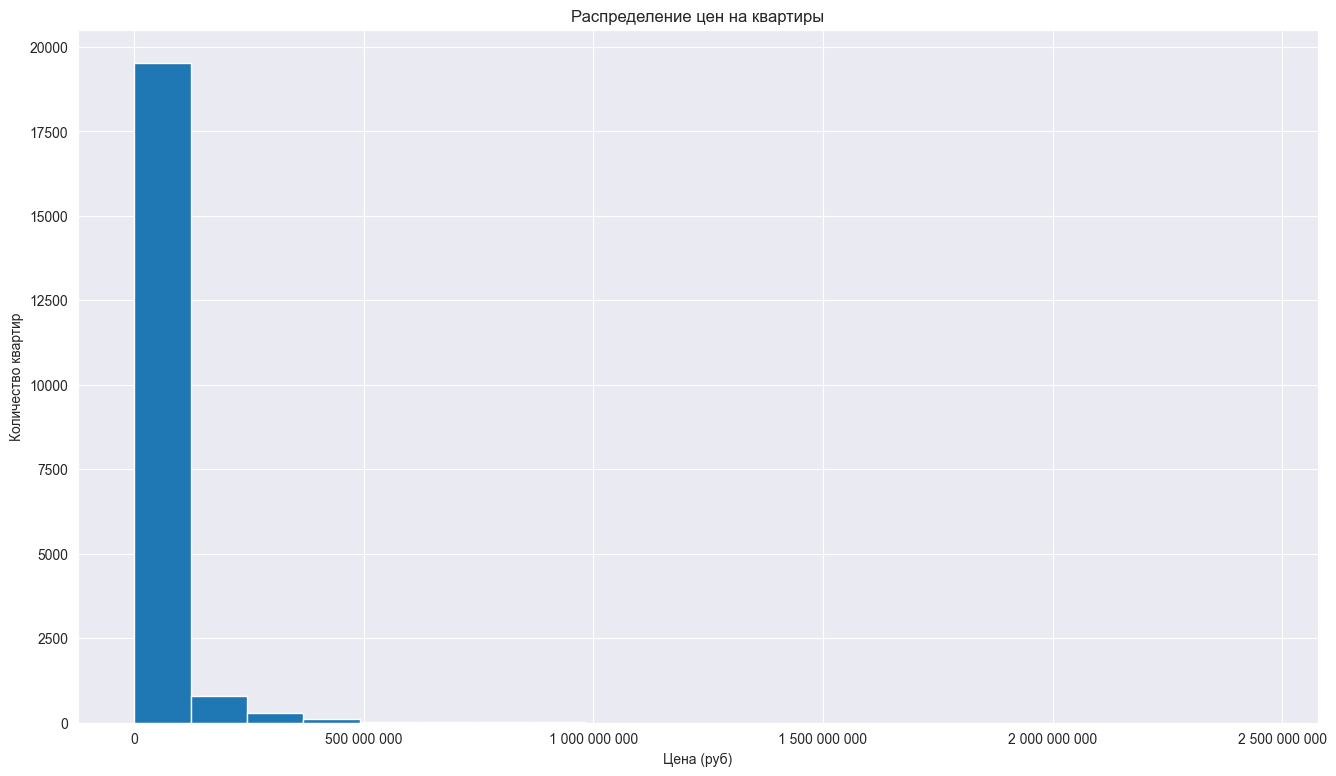

In [ ]:
def price_hist(df):
    plt.figure(figsize=(16, 9))
    plt.hist(df['Price'], bins=20)

    # настройка формата оси x, чтобы цены на графике были понятны
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

    plt.title('Распределение цен на квартиры')
    plt.xlabel('Цена (руб)')
    plt.ylabel('Количество квартир')

    plt.show()

price_hist(df)

График получился не информативным, из-за того, что у нас есть слишком большие значения. Так как таких значений очень мало, можем от них избавиться, чтобы построить более понятный график

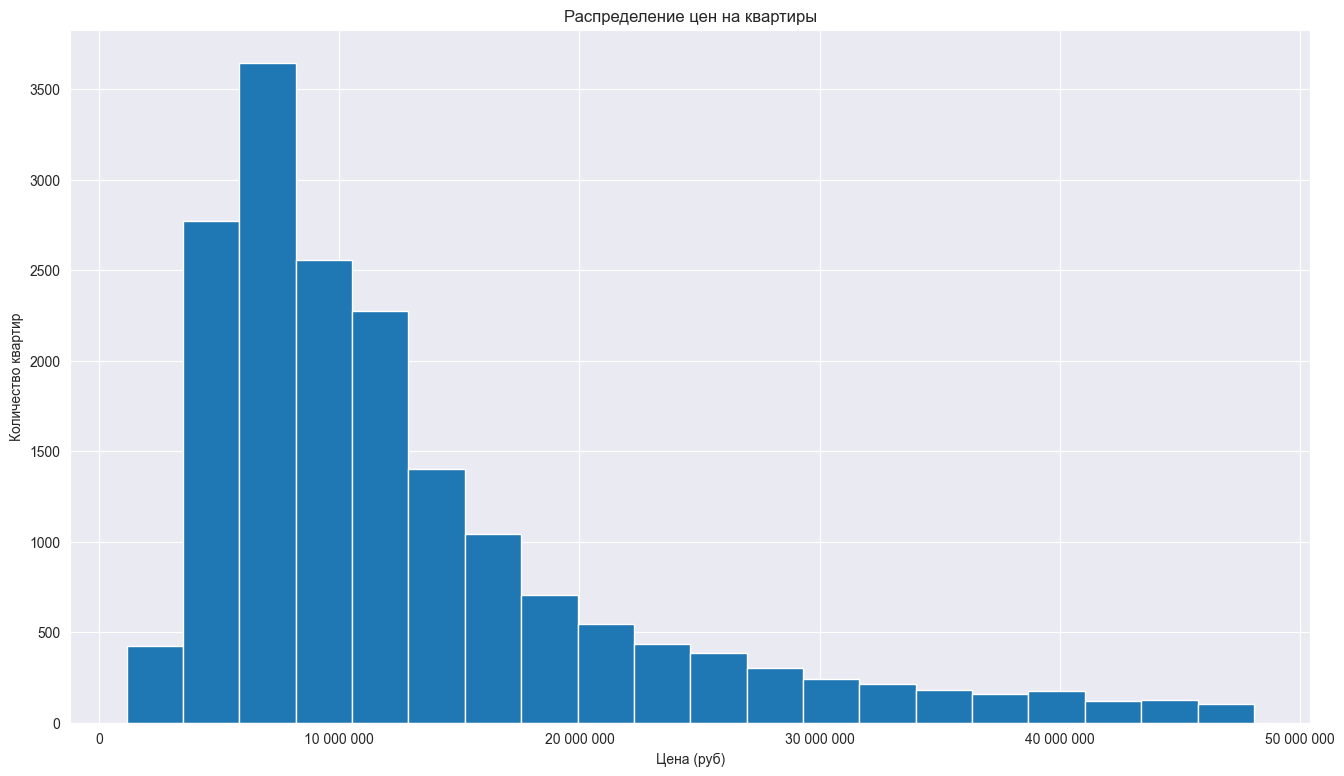

In [ ]:
price_hist(drop_outliers('Price'))

На фильтрованных данных мы видим, что большинство квартир расположены в диаполозне до 10 млн руб.

##### **Выборка 2**: Сравнение количества проданных квартир по районам с помощью диаграммы столбцов.



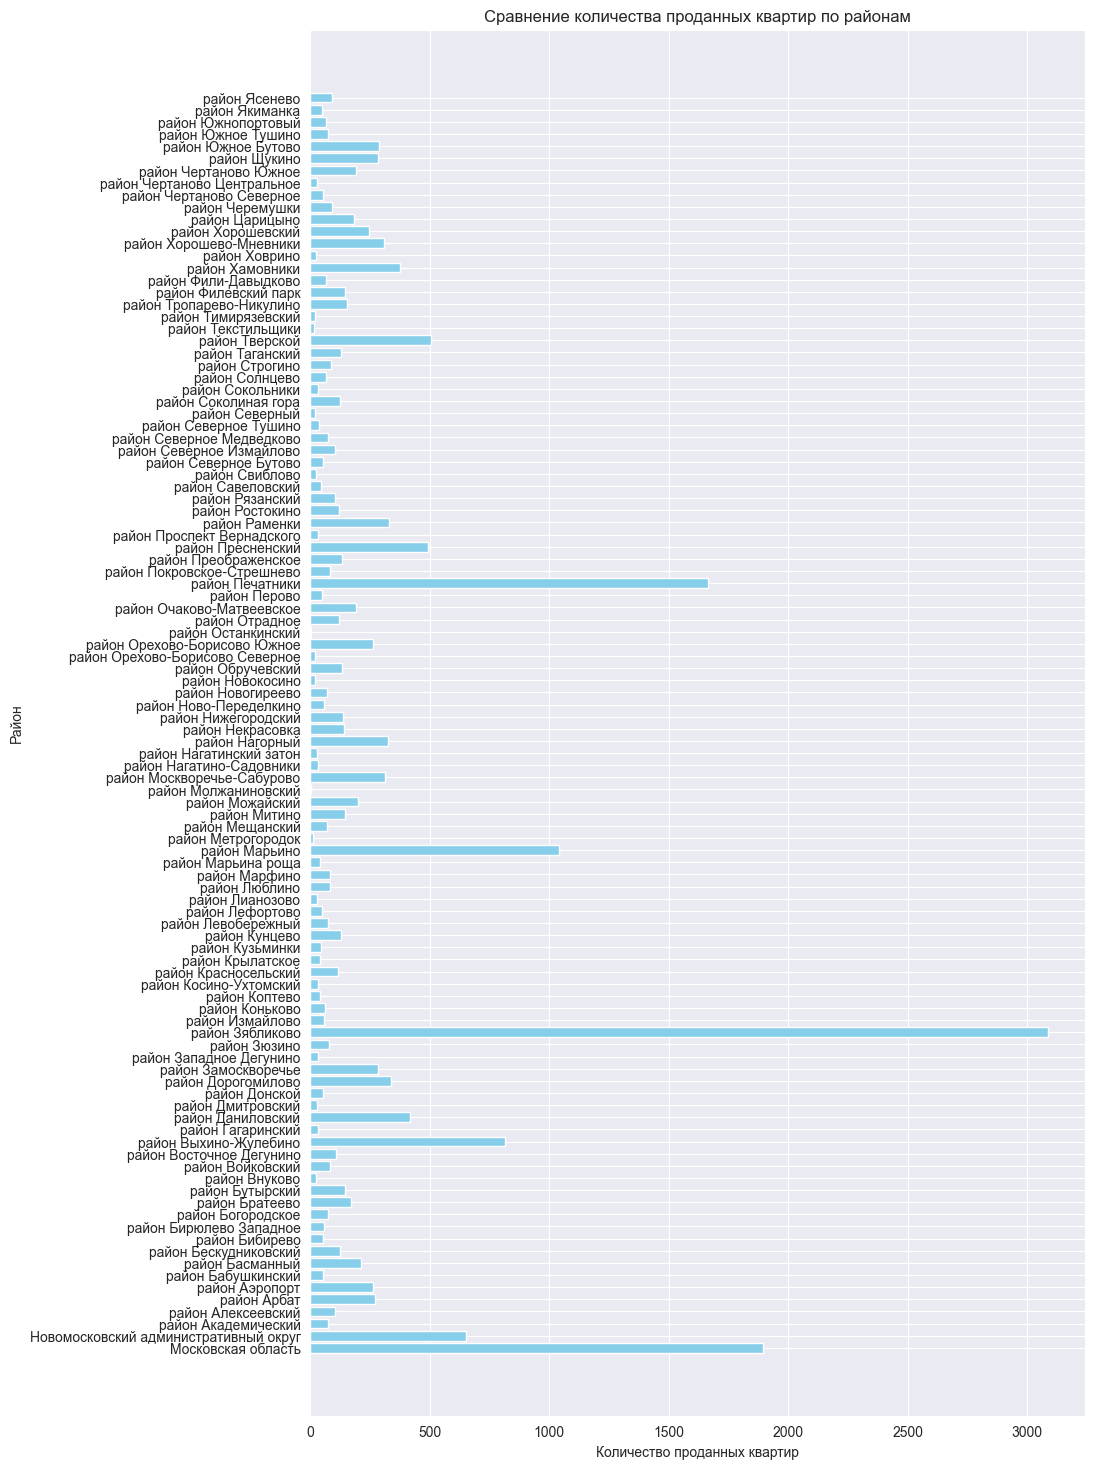

In [ ]:
cnt_houses_by_distr = df.groupby('District').size()
plt.figure(figsize=(10, 18))
plt.barh(cnt_houses_by_distr.index, cnt_houses_by_distr.values, color='skyblue')
plt.xlabel('Количество проданных квартир')
plt.ylabel('Район')
plt.title('Сравнение количества проданных квартир по районам')
plt.show()


Видим, что большинство квартир продано в районах ближе к краю Москвы или за ее пределами. Например, лидер по продажам - Район Зябликово, на втором месте - Московская область.

##### **Выборка 3**: Scatter plot зависимости цены квартиры от площади.

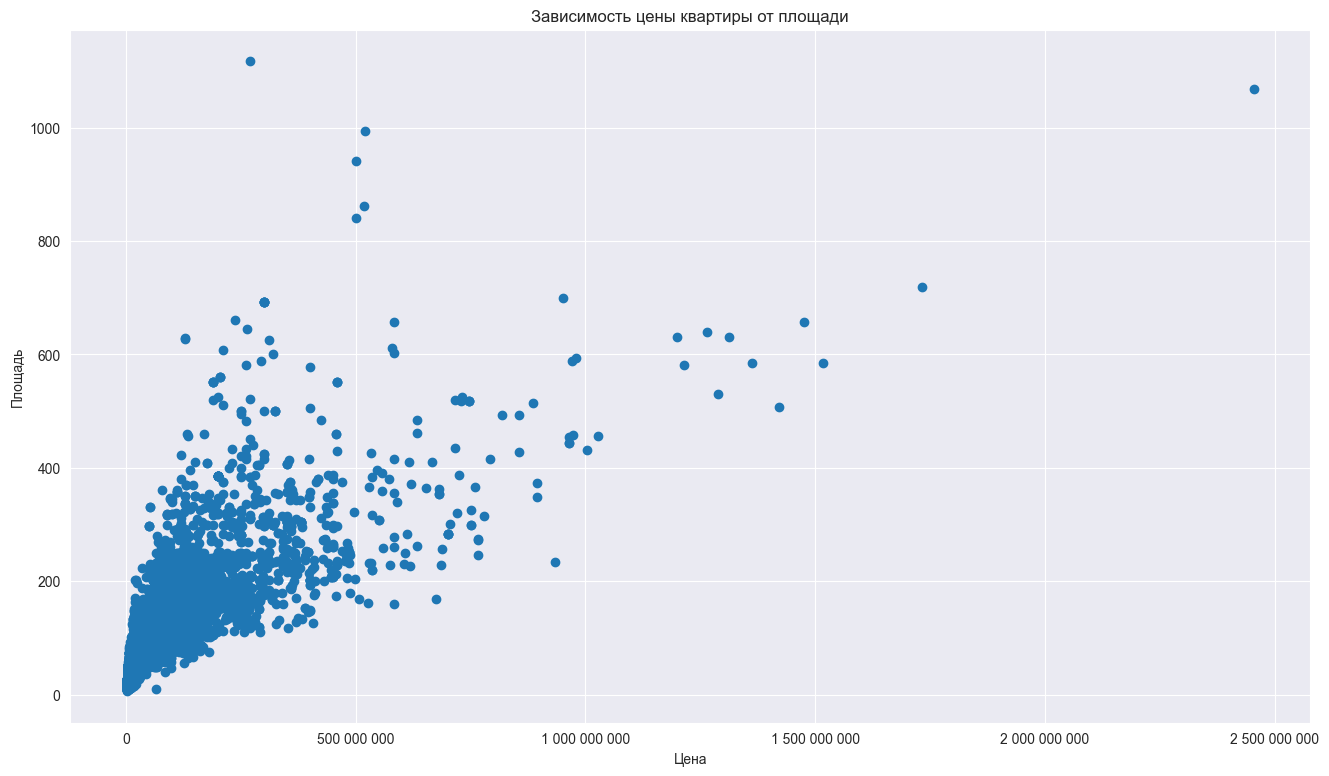

In [ ]:
def scatter(df):
    plt.figure(figsize=(16, 9))
    plt.scatter(df['Price'], df['Area'])

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

    plt.title('Зависимость цены квартиры от площади')
    plt.xlabel('Цена')
    plt.ylabel('Площадь')

    plt.show()

scatter(df)

Попробуем отфильтровать данные так, как мы это делали в Выборке 1

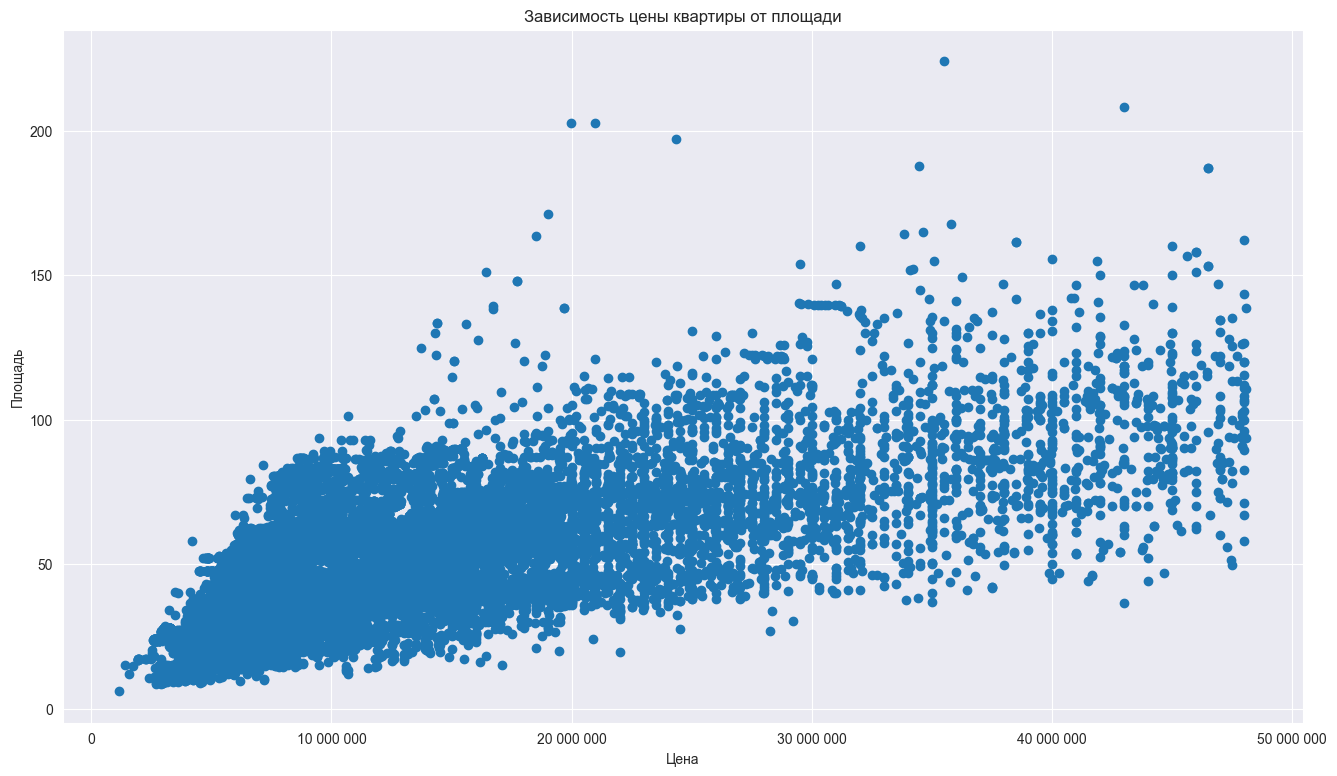

In [ ]:
scatter(drop_outliers('Price'))

На данном графике можно заметить, что существует определенная зависимость между ценой и площадью. Корреляция положительная, что означает, что с увеличением площади увеличивается и цена. Однако можно заметить большую вариабельность данных, это говорит о том, что не только площадь влияет на цену.

##### **Выборка 4**: Сравнение распределения цен квартир, расположенных в разных типах домов c помощью box plot

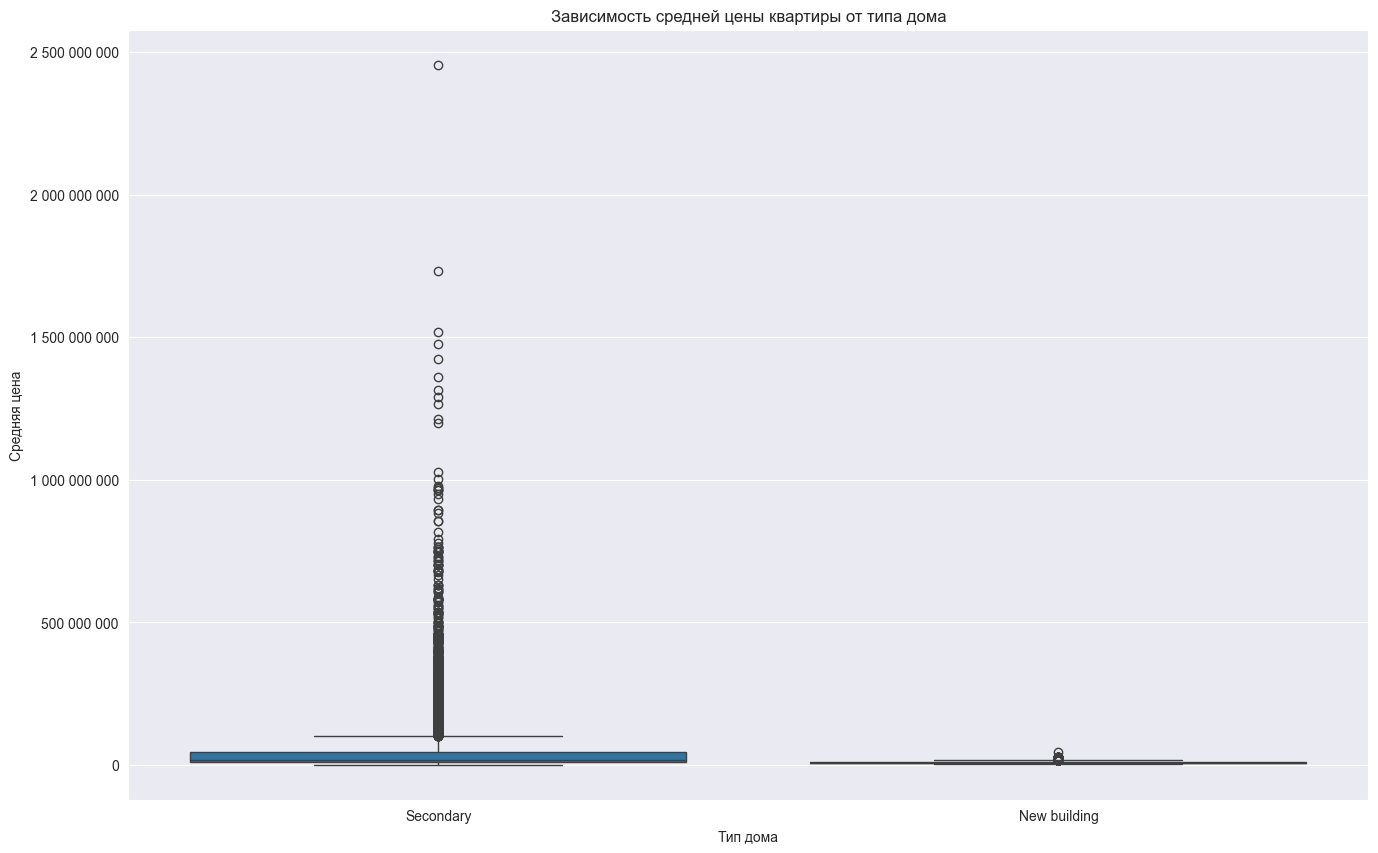

In [ ]:
def type_boxplot(df):
    plt.figure(figsize=(16, 10))
    sns.boxplot(x='Apartment type', y='Price', data=df)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

    plt.title('Зависимость средней цены квартиры от типа дома')
    plt.xlabel('Тип дома')
    plt.ylabel('Средняя цена')
    plt.show()

type_boxplot(df)

С неотфильтрованными данными очень трудно сделать какие-либо выводы. Сделаем те же действия, что и в предыдущих выборках

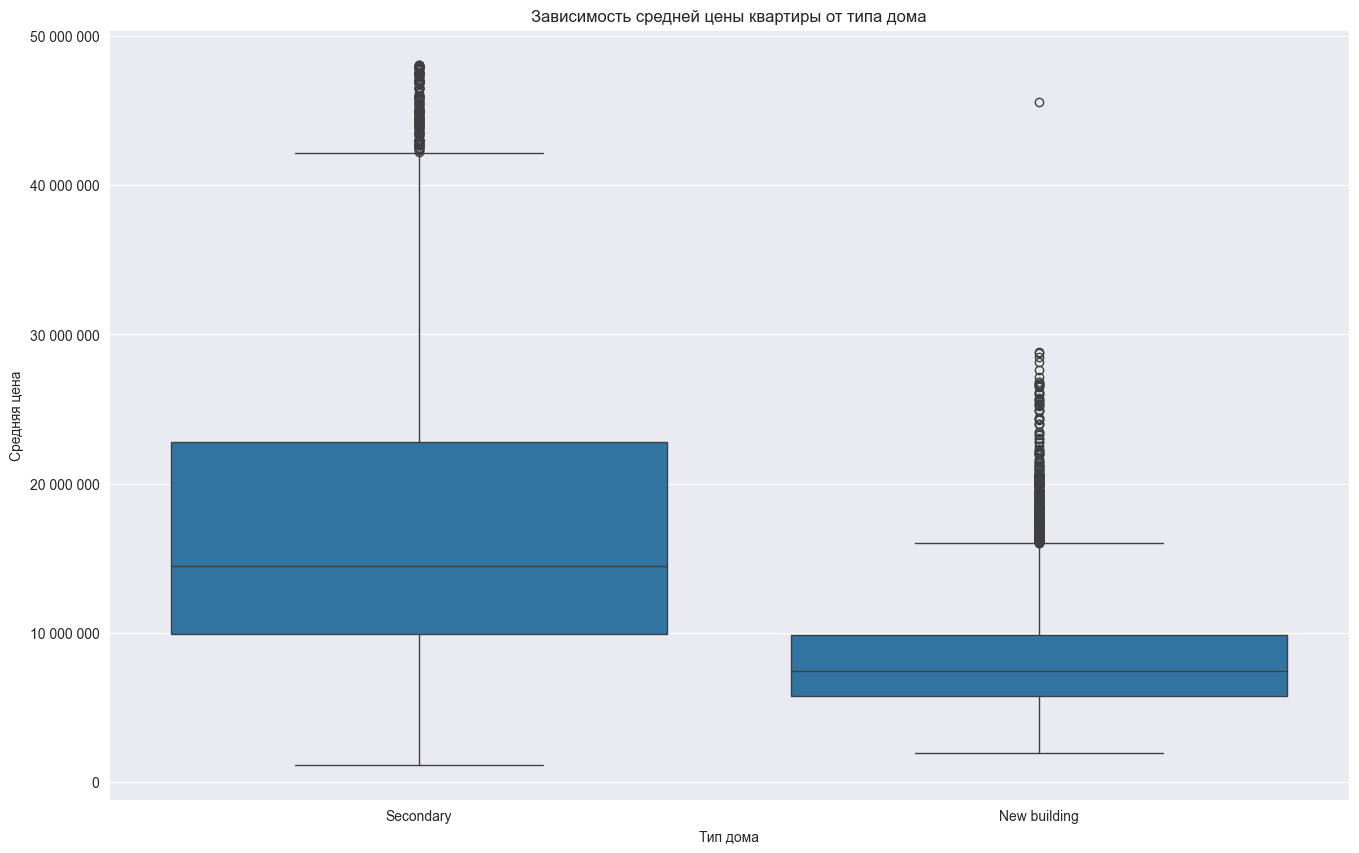

In [ ]:
type_boxplot(drop_outliers('Price'))

**Вторичный рынок:** Квартиры значительно дороже. Это может быть связано с тем, что я описывал в предыдущей выборке: множество квартир вторичного рынка расположены ближе к центру

**Новостройки:** Более низкие цены могут объясняться маркетинговыми стратегиями застройщиков, попытками привлечь покупателей или тем, что новые районы могут быть менее востребованы.

##### **Выборка 5**: Тепловая карта (heatmap) зависимости цены квартиры от района и количества комнат.

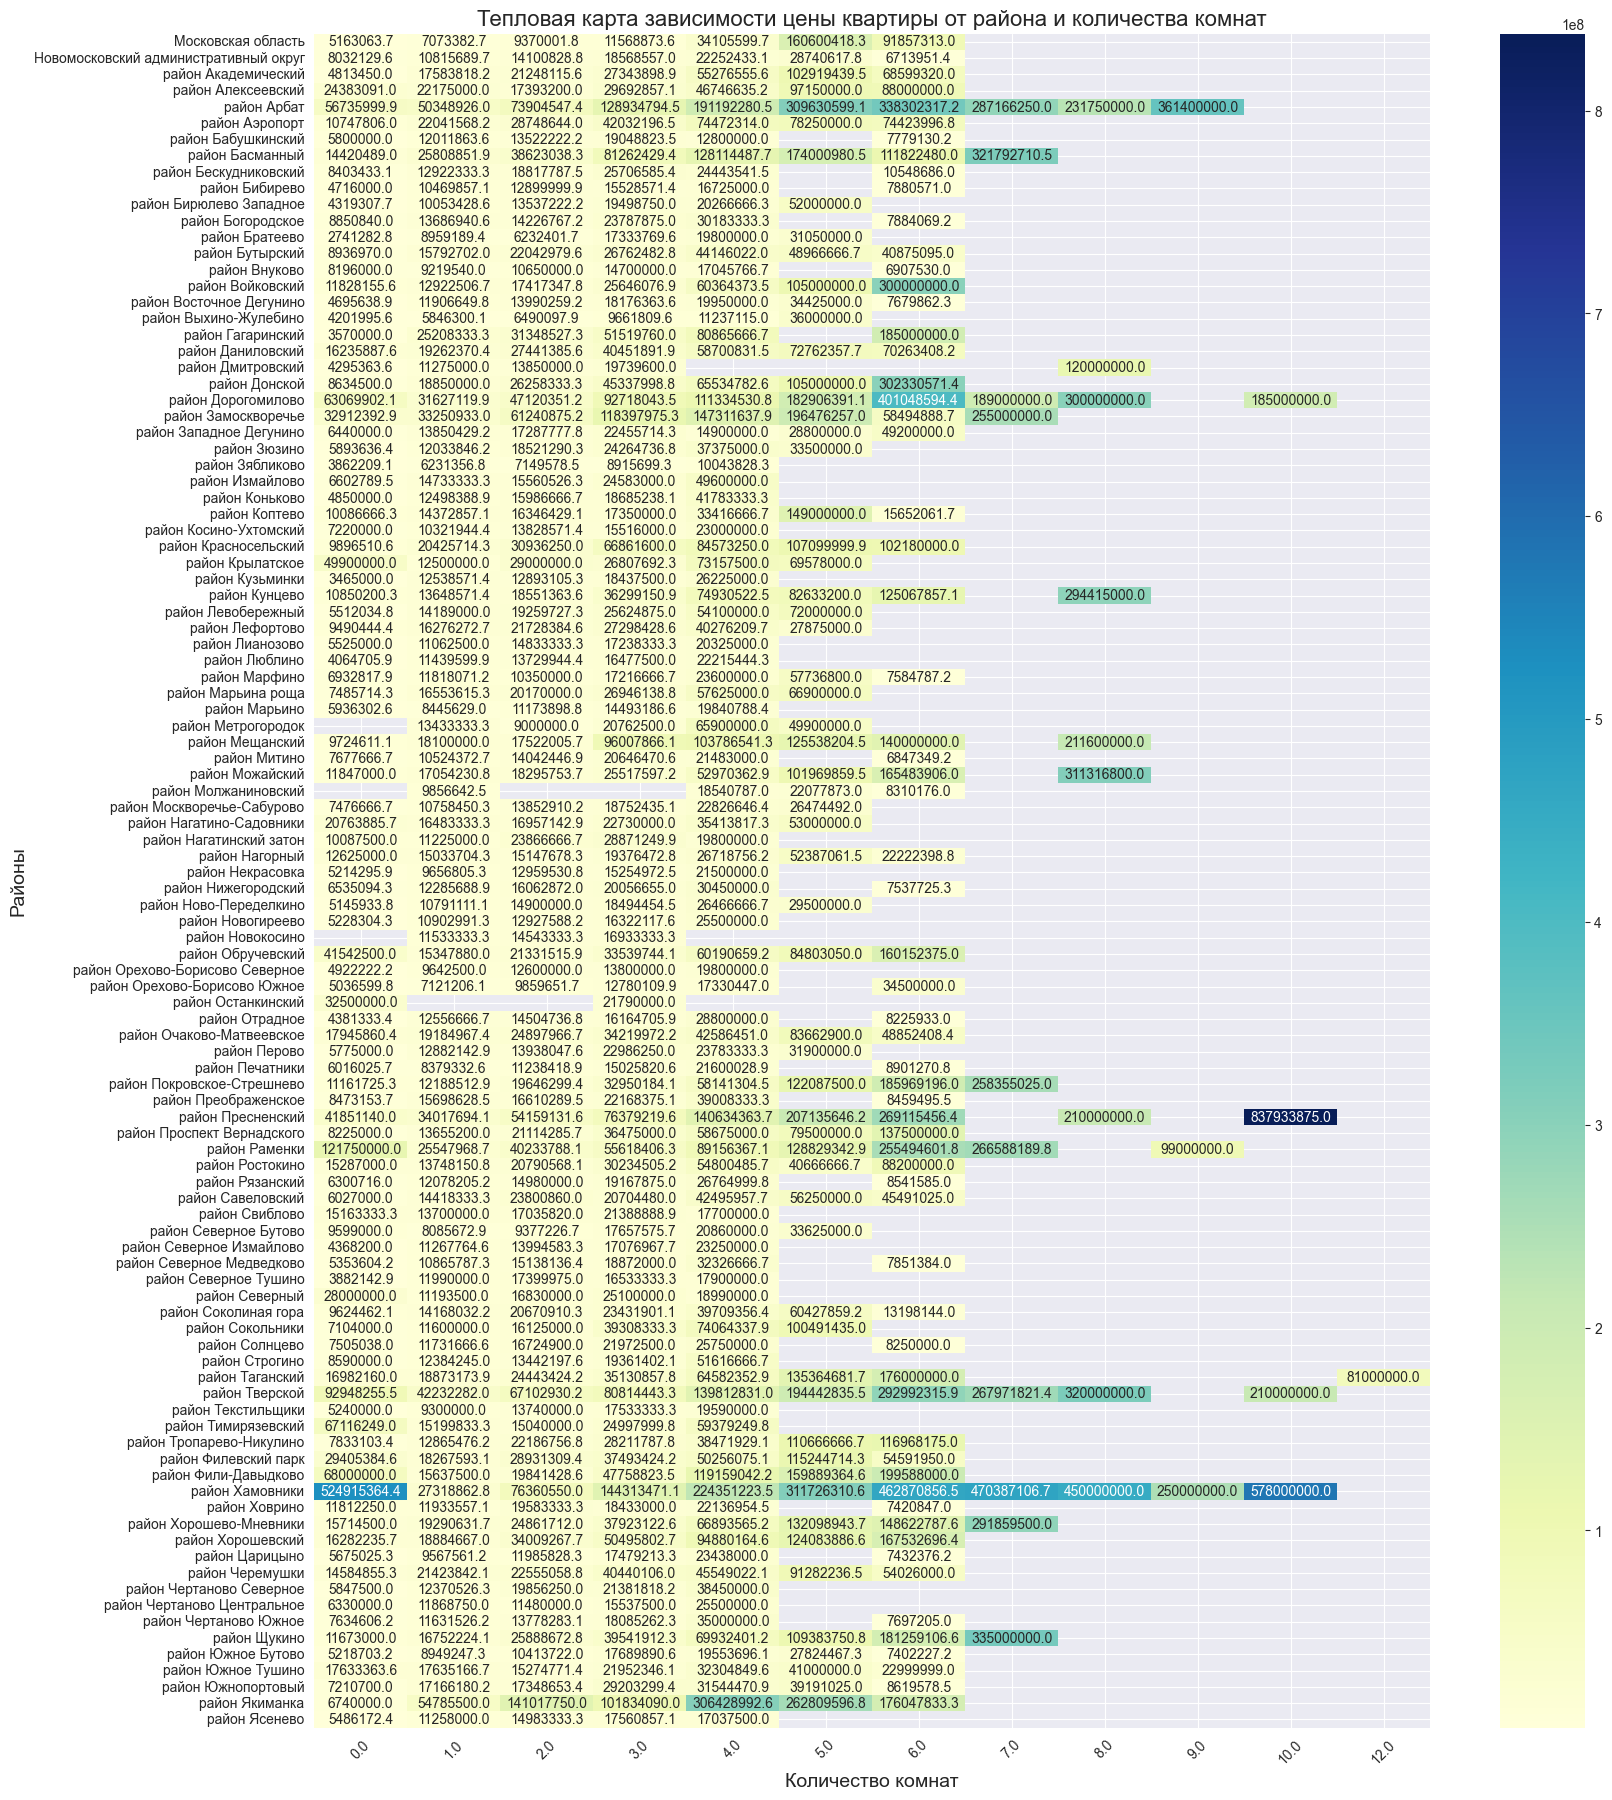

In [ ]:
heatmap_data = df.pivot_table(index='District', columns='Number of rooms', values='Price', aggfunc='mean')

plt.figure(figsize=(18, 22))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")

plt.title('Тепловая карта зависимости цены квартиры от района и количества комнат', fontsize=16)
plt.xlabel('Количество комнат', fontsize=14)
plt.ylabel('Районы', fontsize=14)
plt.xticks(rotation=45)
plt.yticks()
plt.show()

На графике четко видно, что с увеличением комнат увеличивается и цена, но есть множество выбросов. Например, в Хамовниках средняя стоимость студий значительно выше стоимость многокомнатных квартир.

##### **Выборка 6**: Визуализация зависимости цены квартиры от количества комнат с помощью scatter plot

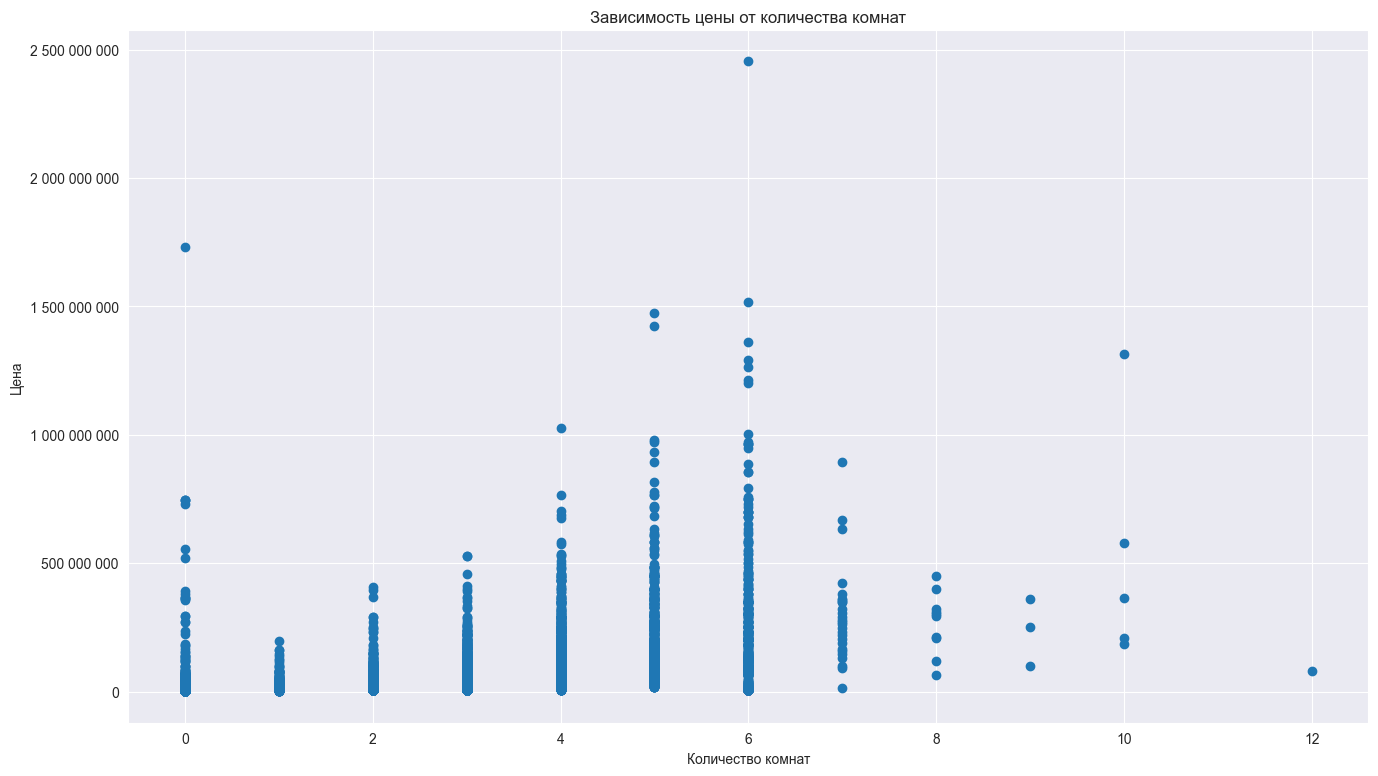

In [ ]:
def rooms_scatter(df):
    plt.figure(figsize=(16, 9))

    plt.scatter(df['Number of rooms'], df['Price'])

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

    plt.title('Зависимость цены от количества комнат')
    plt.xlabel('Количество комнат')
    plt.ylabel('Цена')

    plt.show()

rooms_scatter(df)

Этот график показывает, что цена квартиры имеет тенденцию к увеличению с увеличением количества комнат, но также сильно зависит от других факторов. Присутствие значительных выбросов указывает на то, что есть некоторые элитные или уникальные предложения, которые значительно дороже среднего уровня.

Такие выбросы имеются у каждой категории комнат. Например студия (0 комнат), которая имеет стоимость более 1.5 млрд руб или 12-комнатная квартира со стоимостью менее 500 млн руб.

Попробуем отфильтровать стоимость и построить график снова

##### **Выборка 7**: Карта, отображающая среднюю цену квартир в разных районах Москвы.

In [ ]:
gdf = gpd.read_file('moscow.geojson', encoding='utf-8')

gdf.rename({'district': 'District'}, axis=1, inplace=True) # используем geojson

avg_prices = df.groupby('District')['Price'].mean().reset_index()
merged_df = gdf.merge(avg_prices, left_on='District', right_on='District')

moscow_map = folium.Map(location=[55.7558, 37.6173], zoom_start=10)

# слой с окраской районов
Choropleth(
    geo_data='moscow.geojson',
    data=merged_df,
    columns=['District', 'Price'],
    key_on='feature.properties.district',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='Средняя цена'
).add_to(moscow_map)

# нанесение маркеров
for _, row in merged_df.iterrows():
    lat, lon = row.geometry.centroid.y, row.geometry.centroid.x
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(f"{row['District']}: {row['Price']:.2f} руб", parse_html=True),
    ).add_to(moscow_map)

moscow_map

In [ ]:
gdf.loc[121]

District                             район Чертаново Северное
geometry    POLYGON ((37.5772657 55.6326769, 37.58382 55.6...
Name: 121, dtype: object

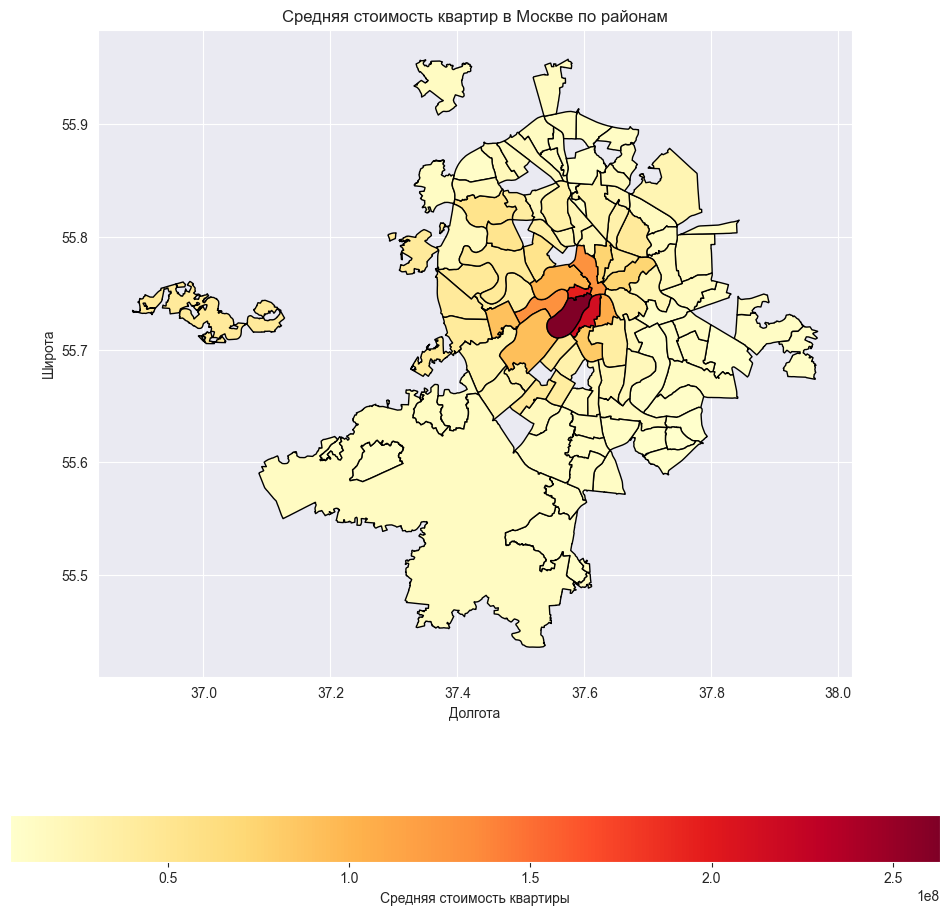

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12)) # создаем фигуру и ось

# отображаем график с легендой с цветовой шкалой
merged_df.plot(column='Price', ax=ax, legend=True,
               legend_kwds={'label': "Средняя стоимость квартиры",
                            'orientation': "horizontal"},
               cmap='YlOrRd', edgecolor='black')

ax.set_title('Средняя стоимость квартир в Москве по районам')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')

plt.show()

В этом задании мы построили два графика:
- Динамический

    На этом графике изображена карта Москвы, на которой каждый район ограничен. Также, изображены всплывающие метки, при нажатии на которые показывается название района и средняя стоимость жилья в нем

- Статический

    На статическом графике изображена карта Москвы без лишнего шума

На обоих графиках имеется цветовое обозначение средней стоимость жилья. Чем теплее, тем выше цена. Черные зоны обозначают то, что в датасете нет данных по квартирам в этих районах

##### **Выборка 8**: Гистограмма распределения площади квартир.

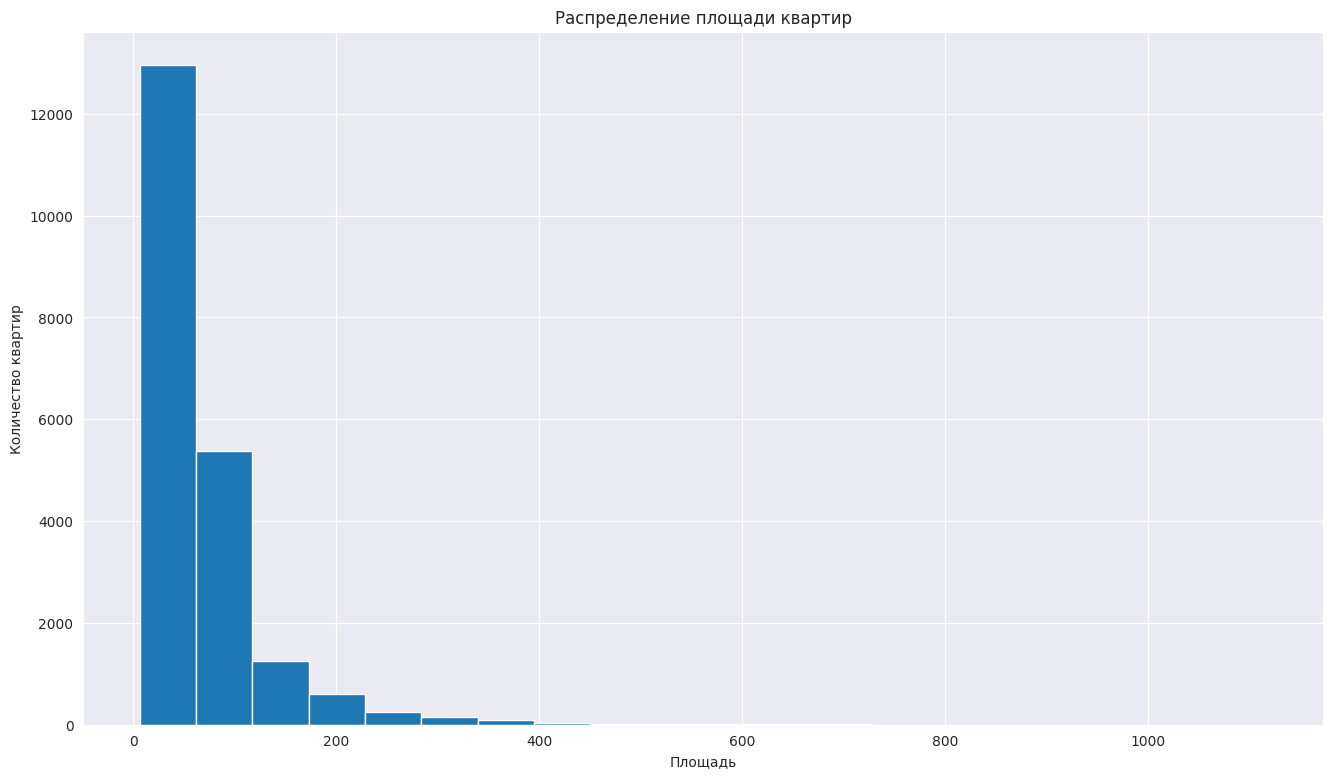

In [ ]:
def area_hist(df):
    plt.figure(figsize=(16, 9))
    plt.hist(df['Area'], bins=20)

    plt.title('Распределение площади квартир')
    plt.xlabel('Площадь')
    plt.ylabel('Количество квартир')

    plt.show()

area_hist(df)

Видно, что большинство квартир имеют площадь до 100 квадратных метров. Попробуем отфильтровать значения, чтобы получить более наглядный график

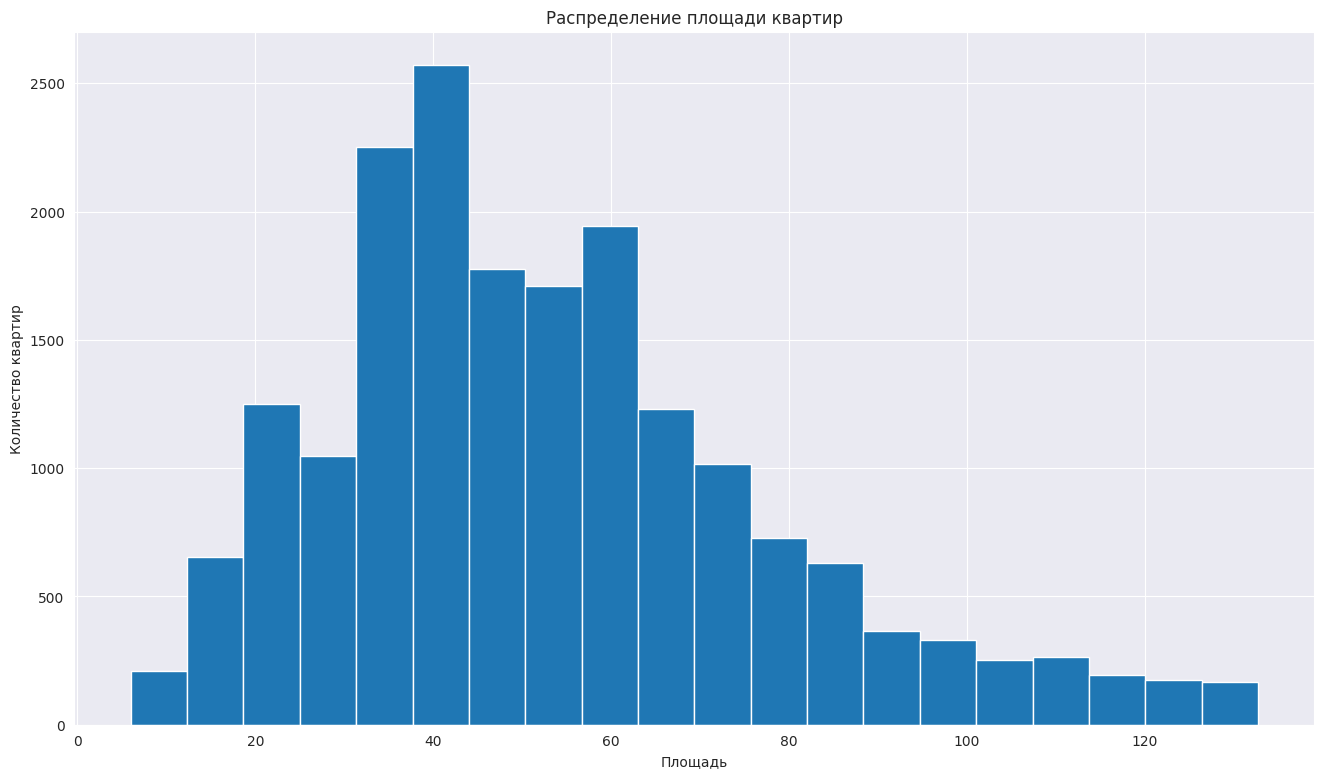

In [ ]:
area_hist(drop_outliers('Area'))

На данном графике видно, что большая часть квартир имеет площадь около 35-50 квадратных метров. Также распределение имеет вид нормального распределения, которое скошенно вправо, что указывает на наличие большего числа квартир с меньшей площадью и постепенно уменьшающееся количество квартир с большей площадью.

# 4. Обучение модели:

In [1]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00


In [11]:
from catboost import CatBoostRegressor, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


import pickle
import json

In [7]:
df = pd.read_csv('moscow_aparts_data.csv')

In [8]:
df.sample(5)

Price Apartment type Metro station  Minutes to metro  \
6872   30900000.0      Secondary      Дубровка               8.0   
19999  17351368.0   New building     Каширская               3.0   
11683   7989000.0      Secondary      Аэропорт               3.0   
11078   4899000.0      Secondary      Отрадное              12.0   
20548   8616652.0   New building      Жулебино              14.0   

       Number of rooms   Area  Living area  Kitchen area  Floor  \
6872               3.0  86.00         53.0          10.0    7.0   
19999              2.0  60.86         32.9          11.7    9.0   
11683              0.0  15.30          9.9           7.9    2.0   
11078              0.0  19.00         11.7           8.2    1.0   
20548              3.0  58.53         38.8           5.9   15.0   

       Number of floors                 Renovation                  District  
6872                  7                   Designer        район Южнопортовый  
19999                10                   Cosmetic  район Нагатино-Садовники  
11683                 4  European-style renovation         район Хорошевский  
11078                 9                   Cosmetic            район Отрадное  
20548                14                   Cosmetic     район Выхино-Жулебино

In [9]:
y = df.Price
X = df.drop(['Price'], axis=1)
cat_features = ['Apartment type','Metro station', 'Renovation', 'District']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

params = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 50
}

cv_results = cv(
    pool=train_pool,
    params=params,
    fold_count=5,
    verbose=100
)

print("Cross-validation results:")
print(cv_results)

model = CatBoostRegressor(**params)

model.fit(train_pool,
          eval_set=test_pool,
          verbose=100,
          early_stopping_rounds=50)


# Make predictions on the test set
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2: {r2:.2f}")
print(f"Test MAE: {mae:.2f}")

Training on fold [0/5]
0:	learn: 88979888.8941369	test: 74268498.9517435	best: 74268498.9517435 (0)	total: 47.2ms	remaining: 47.1s
100:	learn: 38551156.5391235	test: 30782522.7644390	best: 30770806.4117905 (99)	total: 3.01s	remaining: 26.8s
200:	learn: 33205079.9445980	test: 29478261.4403290	best: 29478261.4403290 (200)	total: 6.52s	remaining: 25.9s
300:	learn: 30938603.0557662	test: 28977214.6471737	best: 28949740.8951952 (292)	total: 7.85s	remaining: 18.2s
400:	learn: 28990676.6342381	test: 28620383.5168035	best: 28594311.2539823 (378)	total: 9.18s	remaining: 13.7s
500:	learn: 27444798.4304809	test: 28469673.7024310	best: 28469673.7024310 (500)	total: 10.5s	remaining: 10.4s
600:	learn: 26111337.6278005	test: 28411475.7391703	best: 28396403.0867865 (589)	total: 11.8s	remaining: 7.82s
700:	learn: 25012443.3918944	test: 28269832.3503848	best: 28267209.7631190 (696)	total: 13.7s	remaining: 5.83s
800:	learn: 23813192.2741476	test: 28197660.1280616	best: 28183824.6663480 (790)	total: 15s	r

In [17]:
filename = 'moscow_aparts_predict_model.cb'
pickle.dump(model, open(filename, 'wb'))

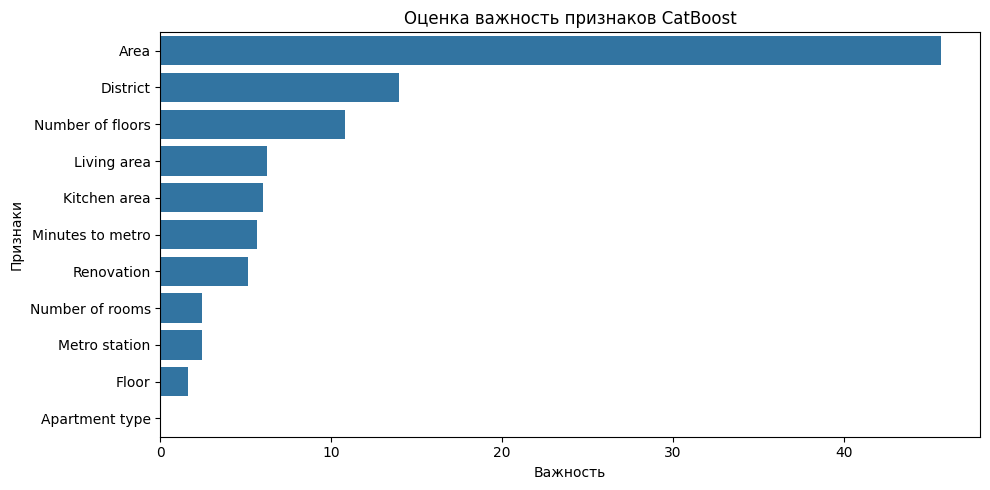

In [14]:
feature_importance = model.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важности признаков CatBoost')
plt.tight_layout()
plt.show()

In [20]:
metro_coords_data = pd.read_csv('metro_stations_dataset.csv')
metro_coords_data.head()

Metro station        lat        lon            District
0       Опалиха  55.824809  37.242265  Московская область
1       Павшино  55.815175  37.341439  Московская область
2      Мякинино  55.823342  37.385214  Московская область
3      Строгино  55.803831  37.402405      район Строгино
4      Нахабино  55.841655  37.184854  Московская область

In [23]:
import json
import pandas as pd
from catboost import Pool
import pickle

def check_point_in_district(lat, lon, districts):
        point = Point(float(lon), float(lat))
        for district_name, polygon in zip(districts['district'], districts['geometry']):
            if polygon.contains(point):
                return district_name
        return

def prepare_data(apartment_data_json, gdf_filename='moscow.geojson', metro_coords_data_filename='metro_stations_dataset.csv'):
    apartment_data = json.loads(apartment_data_json)
    df = pd.DataFrame([apartment_data])
    gdf = gpd.read_file(gdf_filename)
    metro_coords_data = pd.read_csv(metro_coords_data_filename)

    metro_coords_data.drop(['lat', 'lon'], axis=1, inplace=True)
    df = pd.merge(df, metro_coords_data, on='Metro station', how='left')

    cat_features = ['Apartment type', 'Metro station', 'Renovation', 'District']
    predict_pool = Pool(data=df, cat_features=cat_features)

    return predict_pool

def predict_apartment_price(apartment_data_json, model_filename='moscow_aparts_predict_model.cb', gdf_filename='moscow.geojson', metro_coords_data_filename='metro_stations_dataset.csv'):
    loaded_model = pickle.load(open(filename, 'rb'))
    predict_pool = prepare_data(apartment_data_json)
    predicted_price = loaded_model.predict(predict_pool)
    return predicted_price[0]

apartment_data = {
  "Apartment type": "Secondary",
  "Metro station": "Речной вокзал",
  "Minutes to metro": 10,
  "Number of rooms": 2,
  "Area": 50.5,
  "Living area": 30.2,
  "Kitchen area": 8.0,
  "Floor": 5,
  "Number of floors": 9,
  "Renovation": "Cosmetic",
}
apartment_data_json = json.dumps(apartment_data)

with open('apartment_data.json', 'w') as f:
  json.dump(apartment_data, f)

with open('apartment_data.json', 'r') as f:
  apartment_data_from_json = f.read()
predicted_price = predict_apartment_price(apartment_data_from_json)
print(f"Predicted apartment price: {predicted_price}")

Predicted apartment price: 10208149.292828083
